In [1]:
import sys
sys.path.append('/Users/paolamartire/shocks')

import numpy as np
import matplotlib.pyplot as plt

from grid_maker import make_grid
from Utilities.operators import the_nearest
from scipy.optimize import fsolve


In [2]:
num = 45

In [3]:
def the_nearest_inzone(x_zone, y_zone, z_zone, xyz):
    # find the lowest distance to take the nearest point
    temp = 1e8
    for idx in range(len(x_zone)):
        dist = np.linalg.norm(xyz - [x_zone[idx], y_zone[idx], z_zone[idx]])
        if dist < temp:
            temp = dist
            final_idx = idx
            point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])

    return final_idx, point

In [4]:
def temperature_bump(mach):
    """ T_post/ T_pre shock """
    gamma = 5/3
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

In [5]:
def shock_surface(x_array, y_array, z_array, Tgrid, x_zone, y_zone, z_zone, div, dir, Tzone):
    dx = x_array[1] - x_array[0]
    surface_mach = []
    surface_x = []
    surface_y = []
    surface_z = []

    for idx in range(len(x_zone)):
        print(idx)
        point = [x_zone[idx], y_zone[idx], z_zone[idx]]
        div_v = div[idx]
        check_zone = 0
        while check_zone < dx:
            new_point = point + np.multiply(dir[idx],dx)
            i,j,k, nearest  = the_nearest(x_array, y_array, z_array, new_point, dx, 'point')
            next_idx, nearest_zone = the_nearest_inzone(x_zone, y_zone, z_zone, new_point)
            div_next = div[next_idx]
            if div_next < div_v: ### CHECK
                check_zone = 1e4
                print('div lower')
                continue
            check_zone = np.linalg.norm(nearest - nearest_zone)
            point = nearest

        if check_zone < 1e3:
            Tpre = Tgrid[i,j,k]
            Tpost = Tzone[idx]
            surface_x.append(x_array[i])
            surface_y.append(y_array[j])
            surface_z.append(z_array[k])

            def temperature_bump(mach):
                gamma = 5/3
                to_solve =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2) - Tpost/Tpre
                return to_solve
            
            mach = fsolve(temperature_bump, 1)
            print(mach)
            surface_mach.append(mach)
        
        else:
            print('no mach')

    return surface_mach, surface_x, surface_y, surface_z


In [6]:
# Import data
shockzone = np.loadtxt('shockzone_num45.txt')
shockdir = np.loadtxt('shockdir_num45.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [7]:
# make the grid
_, gridded_den, gridded_T, gridded_P, gridded_Vx, gridded_Vy, gridded_Vz, gridded_V, gridded_Rcell, x_radii, y_radii, z_radii = make_grid(num)


all T=0, bro. CHANGE!
Tree built!


In [8]:
surface_mach, surface_x, surface_y, surface_z = shock_surface(x_radii, y_radii, z_radii, gridded_T, x_zone, y_zone, z_zone, div, dir, Tzone)

0
[0.99999953]
1
[1.00023357]
2
[1.0363877]
3
[1.00863952]
4
[1.00923552]
5
[1.04221706]
6
[3.53423939]
7
div lower
no mach
8
div lower
no mach
9
[1.08105377]
10
[1.01400606]
11
[1.00000071]
12
[1.02684569]
13
[1.19318261]
14
[5.70565323]
15
[14.54034481]
16
[7.60700554]
17
[9.24814092]
18
[60.65525048]
19
[5.44686779]
20
[3.60248625]
21
[9.85337881]
22
[8.43521136]
23
[1.69946725]
24
[2.02199371]
25
[1.00027658]
26
[1.00001693]
27
[1.00124161]
28
[1.80009437]
29
[1.79999497]
30
[34.01278765]
31
[17.17159784]
32
[32.38316963]
33
[101.94524503]
34
[87.66033652]
35
[87.65998369]
36
[120.20898662]
37
[120.209086]
38
[52.47150393]
39
[6.50100632]
40
[68.81943304]
41
[44.5561971]
42
[24.08014442]
43
[1.86338842]
44
[1.21035436]
45
[1.00015745]
46
[1.00125027]
47
[1.00133406]
48
[3.2379425]
49
[2.52080185]
50
[81.09775453]
51
[94.16970709]
52
div lower
no mach
53
[120.85551184]
54
div lower
no mach
55
div lower
no mach
56
div lower
no mach
57
div lower
no mach
58
div lower
no mach
59
[144.01

In [9]:
x_toplot = []
y_toplot = []
for idx,z in enumerate(surface_z):
    if np.logical_and(z>-0.04, z<0.04):
        x_toplot.append(surface_x[idx])
        y_toplot.append(surface_y[idx])

Text(0, 0.5, 'Y')

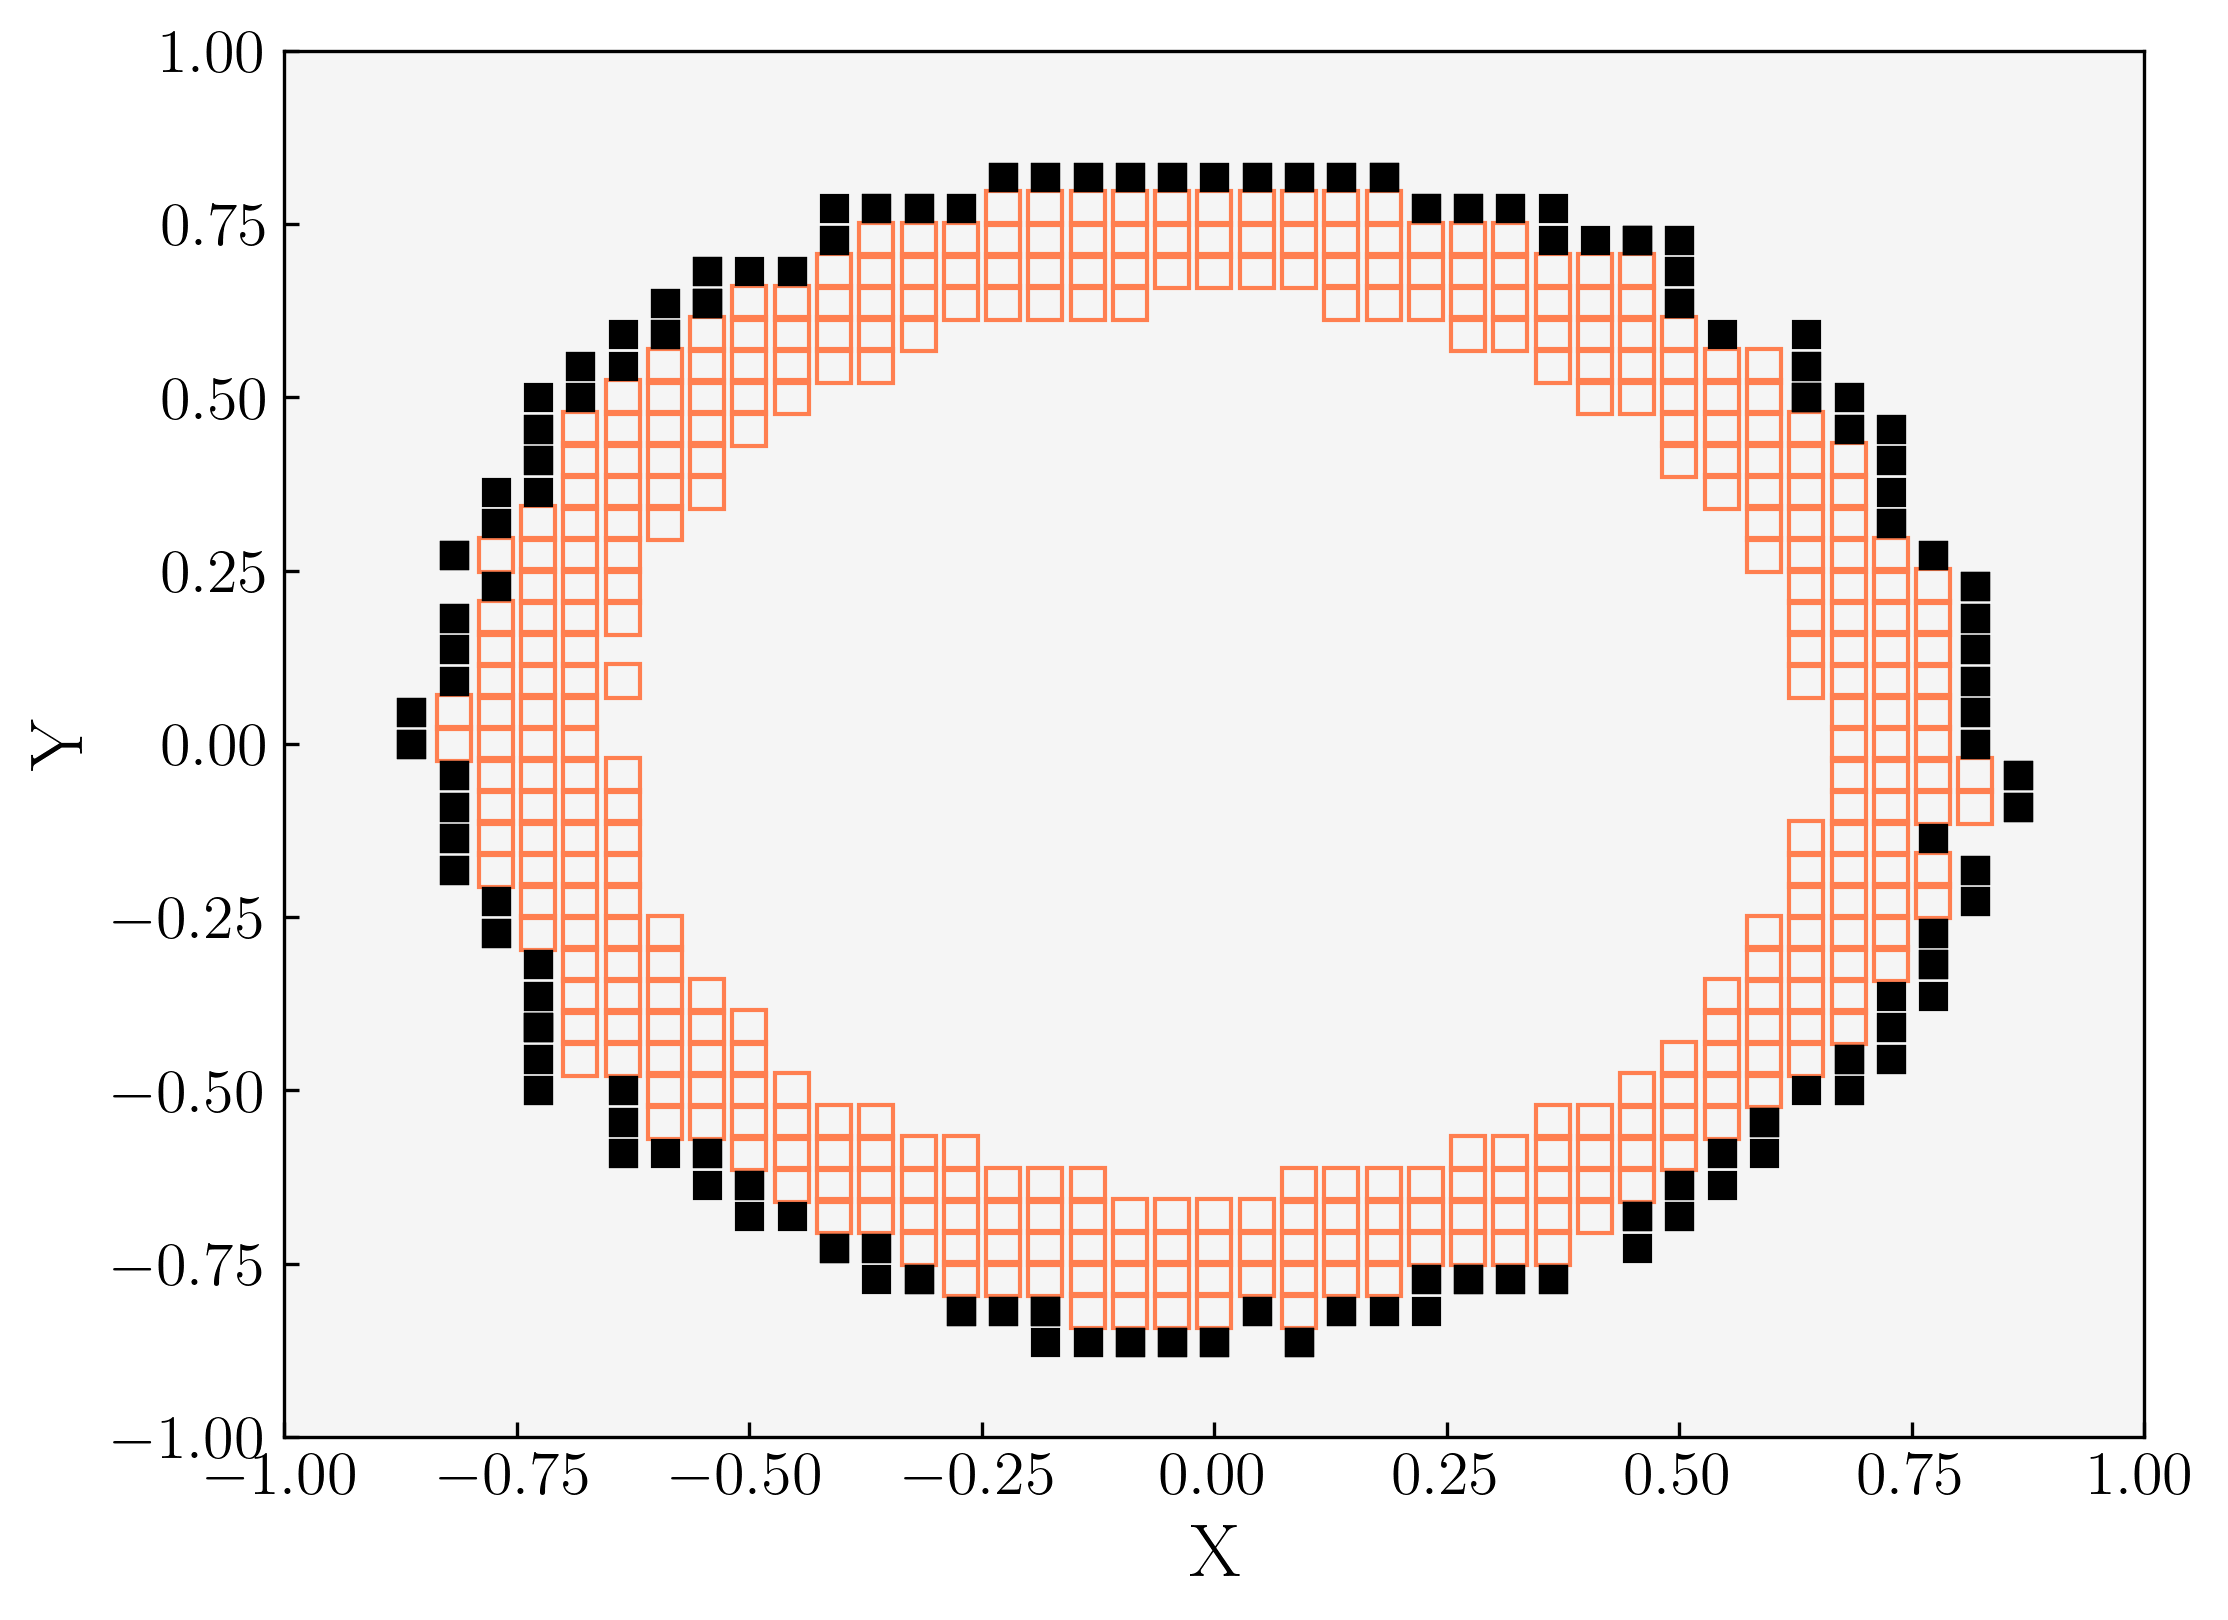

In [12]:
plt.plot(x_zone, y_zone, 'ks', markerfacecolor='none', ms=8, markeredgecolor='coral')
plt.plot(x_toplot, y_toplot, 'ks', markerfacecolor='k', ms=6, markeredgecolor='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)